# TP4 : Reconnaissance de mots isolés par programmation dynamique (DTW)

FOUILHE Guilhem

In [24]:
import numpy as np
from math import floor, inf, dist
import scipy.io.wavfile as wav
import os
import matplotlib.pyplot as plt

# Réutilisation de fonctions pour la lecture et la paramétrisation

In [25]:
# LECTURE d'un fichier Wave
def lecture(fichier, nb_bits):
    
    # Charger un fichier audio
    fs, sig = wav.read(fichier)
    
    # Normaliser le signal entre -1 et 1 pour éviter les dépassements dans les calculs
    signal = sig / 2 ** (nb_bits - 1)
    
    # Durée du signal (en secondes)
    duree = len(signal) / fs
    
    return signal, fs, duree


In [26]:
wav_file = lecture(f"test3.wav", 16)
print(f"Fréquence d'échantillonage (Hz) : {wav_file[1]}\nDurée (s): {wav_file[2]}")

FileNotFoundError: [Errno 2] No such file or directory: 'test3.wav'

In [ ]:
OBS_DIR = "./SIGNAL/OBS"
REF_DIR = "./SIGNAL/REF"

In [27]:
# Calcul de "nbe_coef" coefficients cepstraux
def parametrisation(signal, taille_fenetre, nbe_coef):
    
    # Initialisation de la matrice résultat
    recouvrement = floor(taille_fenetre / 2)
    nb_fen = floor((np.size(signal) - taille_fenetre) / recouvrement) + 1
    mfcc = np.zeros((nb_fen, nbe_coef))
    
    # Calcul des MFCC
    for fen in range(nb_fen):
        p = fen * recouvrement
        spectre = abs(np.fft.fft(np.multiply(signal[p:p + taille_fenetre], np.hamming(taille_fenetre))))
        cepstre = np.fft.fft(np.log(spectre))
        cc = cepstre[1:nbe_coef+1].real
        mfcc[fen, :] = cc

    return mfcc

In [28]:
# Fonction de paramétrisation totale --> tous les fichiers du répertoire 'WAV/APP'
def parametrisation_total(nb_bits, taille_fenetre, nbe_coef, rep_wav, rep_mfcc):
        # Initialisation de la liste des fichiers traités
        liste_fichiers = []
        
        # Parcours de tous les fichiers du répertoire
        for fichier in np.sort(os.listdir(rep_wav)): # Sort pour avoir les fichiers dans l'ordre alphabétique
            
            # Lecture du fichier
            signal, fs, duree = lecture(f"{rep_wav}/{fichier}", nb_bits)
            
            # Paramétrisation du fichier
            mfcc = parametrisation(signal, taille_fenetre, nbe_coef)
            
            # Sauvegarde du fichier
            mfcc_name = fichier.split(".")[0] # Nom du fichier sans l'extension
            np.save(f"{rep_mfcc}/{mfcc_name}", mfcc)
            
            # Ajout du fichier à la liste
            liste_fichiers.append(fichier)
    
        return liste_fichiers
    

In [29]:
MFCC_DIR = "MFCC"
if not os.path.exists(MFCC_DIR):
    os.mkdir(MFCC_DIR)

# Exemple :
taille_fenetre = 320
nbe_coef = 12
liste_fichiers = parametrisation_total(16, taille_fenetre, nbe_coef, OBS_DIR, MFCC_DIR)
print(f"Noms des fichiers traités : {liste_fichiers}")
print(f"Nombre de fichiers traités : {len(liste_fichiers)}")

Noms des fichiers traités : ['alpha.wav', 'bravo.wav', 'charlie.wav', 'delta.wav', 'echo.wav', 'foxtrott.wav', 'golf.wav', 'hotel.wav', 'india.wav', 'juliett.wav', 'kilo.wav', 'lima.wav', 'mike.wav']
Nombre de fichiers traités : 13


# Programmation dynamique

In [30]:
# Calcul de la DTW entre deux vecteurs
def dtw(mfcc_ref, mfcc_obs):
        
        # Initialisation de la matrice de coût
        nb_fen_ref = mfcc_ref.shape[0]
        nb_fen_obs = mfcc_obs.shape[0]
        matrice_cout = np.zeros((nb_fen_ref+1, nb_fen_obs+1))
        matrice_cout[0, 1:] = np.inf
        matrice_cout[1:, 0] = np.inf

        # Calcul de la matrice de coût
        for i in range(1, nb_fen_ref+1):
            for j in range(1, nb_fen_obs+1):
                d_ij = np.linalg.norm(mfcc_ref[i-1, :] - mfcc_obs[j-1, :])
                matrice_cout[i, j] = np.min([matrice_cout[i-1, j]+1*d_ij, matrice_cout[i, j-1]+1*d_ij, matrice_cout[i-1, j-1]+2*d_ij]) 
        
        # Calcul du coût normalisé
        cout_normalise = matrice_cout[nb_fen_ref, nb_fen_obs] / (nb_fen_ref + nb_fen_obs)
        return cout_normalise

In [31]:
# DTW sur toutes les observations par rapport à toutes les références
def DTW_total(nb_bits, taille_fenetre, nbe_coef, rep_mfcc_ref, rep_wave_obs):
        
        # Initialisation de la matrice de coûts
        nb_fichier_ref = len(os.listdir(rep_mfcc_ref))
        nb_fichier_obs = len(os.listdir(rep_wave_obs))
        matrice_cout = np.zeros((nb_fichier_obs, nb_fichier_ref))
        
        # Calcul de la matrice de coûts
        for i, obs_file_name in enumerate(np.sort(os.listdir(rep_wave_obs))): # Sort pour avoir les fichiers dans l'ordre alphabétique
            # Lecture de l'observation
            signal_obs, fs_obs, duree_obs = lecture(f"{rep_wave_obs}/{obs_file_name}", nb_bits)
            
            # Paramétrisation de l'observation
            mfcc_obs = parametrisation(signal_obs, taille_fenetre, nbe_coef)
            
            for j, ref_file_name in enumerate(np.sort(os.listdir(rep_mfcc_ref))):
                # Lecture de la référence
                mfcc_ref = np.load(f"{rep_mfcc_ref}/{ref_file_name}")
                
                # Calcul de la DTW
                matrice_cout[i, j] = dtw(mfcc_ref, mfcc_obs)
        
        return matrice_cout

# Affichages et tests

In [32]:
# Initialisation
q = 16
taille_fenetre = 1024
nbe_coef = 16
rep_ref = 'SIGNAL/REF'
rep_obs = 'TEST'
rep_mfcc = 'MFCC'

In [33]:
# Paramétrisation des fichiers références
liste_fichiers_ref = parametrisation_total(q, taille_fenetre, nbe_coef, rep_ref, rep_mfcc)

In [34]:
# DTW sur toutes les observations par rapport à chaque référence
matrice_cout = DTW_total(q, taille_fenetre, nbe_coef, rep_mfcc, rep_obs)
# Affichage des couts
print(matrice_cout)

[[495.28069458 546.21136138 675.23565057 502.80348159 601.6595245
  433.95523475 582.61650337 590.64487657 570.76951025 556.5341464
  595.10765131 555.51406836 529.43622093]]


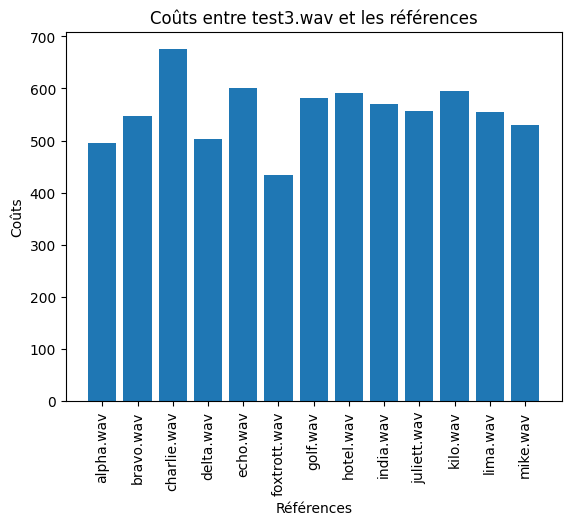

In [35]:
# Affichage amélioré
for i, obs_file_name in enumerate(np.sort(os.listdir(rep_obs))):
    plt.figure()
    plt.bar(np.sort(os.listdir(rep_ref)), matrice_cout[i, :])
    plt.title(f"Coûts entre {obs_file_name} et les références")
    plt.xticks(rotation=90)
    plt.xlabel("Références")
    plt.ylabel("Coûts")
    plt.show()
